In [1]:
import numpy as np
import h5py
from sklearn.model_selection import ParameterGrid
from scipy.stats import linregress
from mirdata import tinysol
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import os
import glob

import librosa
from librosa import load
from librosa import cqt
from librosa.display import specshow

from utilities.isomapEmbedding import isomapEmbedding
from utilities.convex_fit import convex_fit
from utilities.circle_projection import circle_projection

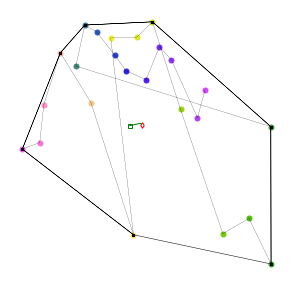

In [2]:
dataset = "ENST-drums-public"

Q = 24
settings = {
    'Q': [24],
    'k': [3],
    'comp': ['log'],
    'instr': ['']
}
settings_list = ParameterGrid(settings)

losses = {}
radii = {}
for setting in settings_list:
    # read precomputed features
    with h5py.File("{}.h5".format(dataset), "r") as f:
        features_dict = {
            key:f[key][()]
            for key in f.keys()
            if setting['instr'] in key
        }
    batch_features = np.stack(list(features_dict.values()), axis=1)

    # compute isomap for subset
    isomap, _, rho_std = isomapEmbedding(batch_features)
    xyz_coords = isomap.fit_transform(rho_std)

    # Average across octaves 
    m = xyz_coords.shape[0]
    ids = [0, int(m // 3), int(2 * m // 3)]
    xyz_octave = (xyz_coords[ids[0]:ids[1]] + xyz_coords[ids[1]:ids[2]] + xyz_coords[ids[2]:]) / 3

    # convex hull fit, line fit
    xy_coords = xyz_octave[:, :2]
    xy_center, radius, returns_dict = convex_fit(xy_coords)
    xy_prime = circle_projection(xy_center, radius, xy_coords) # projected (x,y) coordinates

    z = xyz_octave[:, -1]
    z_fit = linregress(np.arange(len(z)), z)
    z_prime = np.asarray([i * z_fit.slope + z_fit.intercept for i, _ in enumerate(z)]) # projected z coordinates

    xyz_prime = np.concatenate((xy_prime, z_prime[:, np.newaxis]), axis=1)
    
    # Euclidean projection loss
    diffs_squared = (xyz_octave - xyz_prime) ** 2
    d_euclideans = np.sqrt(np.sum(diffs_squared, axis=1))
    loss = np.mean(d_euclideans)

    losses[setting['instr']] = loss
    radii[setting['instr']] = radius

    # Plot Frank-wolfe convergence plot
    hull_vertices = returns_dict['hull_vertices']
    hull_center = returns_dict['hull_center']
    centers = returns_dict['centers']

    plt.figure(figsize=(5, 5))
    plt.axis("off")
    plt.plot(
        np.concatenate([hull_vertices[:, 0], hull_vertices[0:, 0]]), 
        np.concatenate([hull_vertices[:, 1], hull_vertices[0:, 1]]),
        '-s', color='k', linewidth=0.5, markersize=2.0)
    plt.plot(hull_center[np.newaxis, 0], hull_center[np.newaxis, 1], 
            'd', color='r', markersize=4.0, fillstyle='none', linewidth=0.5)
    plt.plot(centers[:, 0], centers[:, 1], '-', color='g', linewidth=1.0)
    plt.plot(centers[-1, 0], centers[-1, 1], 's', color='g', markersize=4.0, fillstyle='none', linewidth=0.5)

    import colorcet as cc
    color_ids = np.floor(np.linspace(0, 256, Q, endpoint=False)).astype("int")
    color_list = [cc.cyclic_mygbm_30_95_c78[i] for i in color_ids]

    # Plot embedding with color
    n_points = xy_coords.shape[0]
    for i in range(n_points):
        plt.scatter(xy_coords[i, 0], xy_coords[i, 1], color = color_list[i%Q], s=25.0)
    plt.plot(xy_coords[:, 0], xy_coords[:, 1], color="black", linewidth=0.2)

In [9]:
(xyz_coords[ids[0]:ids[1]] + xyz_coords[ids[1]:ids[2]]).shape

(24, 3)